In [ ]:
from google.colab import files
files.upload() # Upload your kaggle API Key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucasnoritomihartwig","key":"88cf2e35b096aa209fe282b8dee6e5b3"}'}

In [ ]:
# Installing required packages
!pip install arxiv
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=e87044798172f3e9802fd1c3ee907ed3e033484c38e2b928e7a53401e2a6c91e
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

# Create the directories for original data
!rm -rf ./dataset/
!kaggle datasets download -d Cornell-University/arxiv
!unzip arxiv.zip > /dev/null

 99% 1.20G/1.21G [00:15<00:00, 50.1MB/s]
100% 1.21G/1.21G [00:15<00:00, 85.3MB/s]


In [ ]:
!ls -lah /content/

total 4.9G
drwxr-xr-x 1 root root 4.0K Nov 10 00:05 .
drwxr-xr-x 1 root root 4.0K Nov 10 00:03 ..
-rw-r--r-- 1 root root 3.7G Nov  4 23:53 arxiv-metadata-oai-snapshot.json
-rw-r--r-- 1 root root 1.3G Nov  4 23:58 arxiv.zip
drwxr-xr-x 4 root root 4.0K Nov  8 14:27 .config
drwxr-xr-x 1 root root 4.0K Nov  8 14:27 sample_data


In [ ]:
import pandas as pd

# This crashes the runtime environment
df = pd.read_json("/content/arxiv-metadata-oai-snapshot.json", lines=True)
df.head()

## Count distinct words in title

In [ ]:
import json
from collections import Counter
import re

# Function to extract unique words from a given text
def extract_unique_words(text):
    # Use regex to split the text into words
    words = re.findall(r'\w+', text.lower())  # Convert to lowercase and split into words
    return set(words)


# Initialize a Counter to count unique words
unique_word_counter = Counter()

# Open the JSON file and process it line by line
# File from https://www.kaggle.com/datasets/Cornell-University/arxiv/
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse the JSON object in each line
            if 'title' in data:
                title = data['title']
                unique_words = extract_unique_words(title)
                unique_word_counter.update(unique_words)
        except json.JSONDecodeError:
            pass  # Skip lines that are not valid JSON

# Count the total number of unique words
total_unique_words = len(unique_word_counter)

# Print the result
print(f"Total number of unique words in paper titles (vocabulary size): {total_unique_words}")

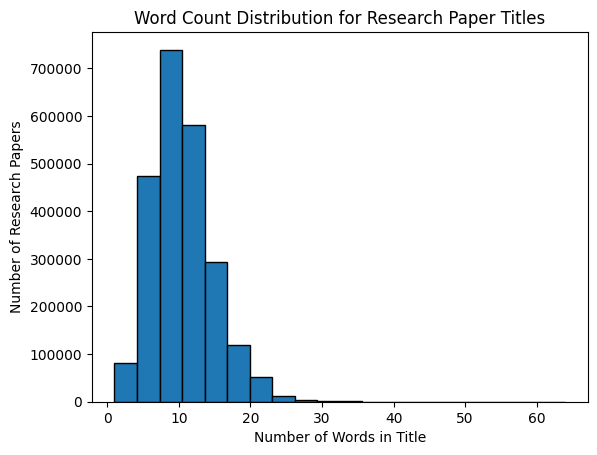

In [ ]:
import json
import re
import matplotlib.pyplot as plt

# Function to extract the number of words from a given text
def count_words(text):
    words = re.findall(r'\w+', text)  # Split the text into words
    return len(words)

# Initialize a list to store the word counts for titles
title_word_counts = []

# Open the JSON file and process it line by line
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse the JSON object in each line
            if 'title' in data:
                title = data['title']
                word_count = count_words(title)
                title_word_counts.append(word_count)
        except json.JSONDecodeError:
            pass  # Skip lines that are not valid JSON

# Create a histogram
plt.hist(title_word_counts, bins=20, edgecolor='k')  # Adjust the number of bins as needed
plt.title('Word Count Distribution for Research Paper Titles')
plt.xlabel('Number of Words in Title')
plt.ylabel('Number of Research Papers')
plt.show()


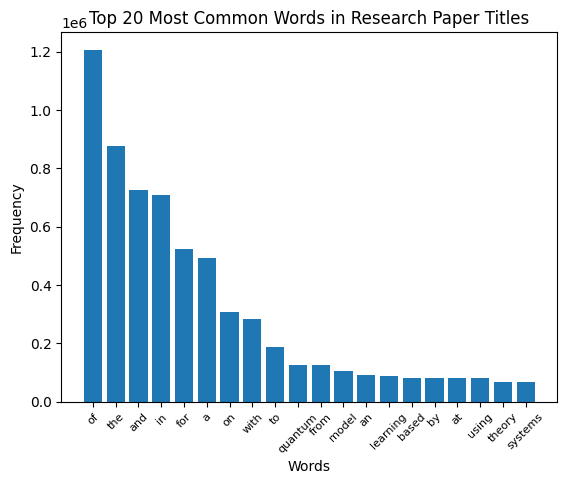

In [ ]:
import json
import re
import matplotlib.pyplot as plt
from collections import Counter

# Function to extract unique words from a given text
def extract_unique_words(text):
    words = re.findall(r'\w+', text.lower())  # Convert to lowercase and split into words
    return words

# Initialize a Counter to count word frequencies
word_counter = Counter()

# Open the JSON file and process it line by line
with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse the JSON object in each line
            if 'title' in data:
                title = data['title']
                words = extract_unique_words(title)
                word_counter.update(words)
        except json.JSONDecodeError:
            pass  # Skip lines that are not valid JSON

# Get the most common words and their frequencies
most_common_words = word_counter.most_common(20)  # You can change 10 to show a different number of words

# Extract words and frequencies
words, frequencies = zip(*most_common_words)

# Create a bar graph
plt.bar(words, frequencies)
plt.xticks(rotation=45, fontsize=8)
plt.title('Top 20 Most Common Words in Research Paper Titles')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



In [ ]:
train_path = '/content/drive/My Drive/Colab Notebooks/data/arxiv.txt' 

In [ ]:
import torch
import torchtext

# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=50)

In [ ]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.encoder_rnn = nn.GRU(input_size=emb_size,
                                  hidden_size=hidden_size,
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size,
                                  hidden_size=hidden_size,
                                  batch_first=True)
        self.proj = nn.Linear(in_features=hidden_size,
                              out_features=vocab_size)

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        The (seq_length - 1) part is not a typo. If you don't understand why
        we need to subtract 1, refer to the teacher-forcing diagram above.
        """


        h = self.encode(inp)

        #Initialize the input for the decoder with the <bos> token
        decoder_input = inp[:, :-1]  # Remove the last word from the sequence
        decoder_input = F.one_hot(decoder_input, num_classes=self.proj.out_features).float()

        # Decode using teacher forcing
        decoder_output, hidden_state= self.decode(decoder_input, h)

        return decoder_output